let's move on to **Lasso Regression (L1 Regularization)**.

Lasso stands for **Least Absolute Shrinkage and Selection Operator**. It's another powerful regularization technique that, like Ridge, aims to prevent overfitting and improve the generalization of linear models. However, it has a distinct property that makes it very useful for feature selection.

---
**3. Lasso Regression (L1 Regularization)**

* **Penalty Term:** Lasso Regression adds a penalty proportional to the **sum of the absolute values of the coefficient magnitudes** (also known as the L1 norm of the coefficients). Again, the intercept ($b_0$) is typically not regularized.
    $$\text{Penalty}_{L1} = \alpha \sum_{j=1}^{p} |b_j|$$
* **Cost Function for Lasso:**
    $$J_{Lasso}(b) = MSE + \alpha \sum_{j=1}^{p} |b_j|$$
* **Hyperparameter $\alpha$ (alpha):**
    * Similar to Ridge, $\alpha$ controls the strength of the regularization. It's a non-negative value.
    * If $\alpha = 0$: Lasso Regression becomes identical to OLS Linear Regression.
    * As $\alpha$ increases: The penalty becomes more significant. Due to the nature of the L1 penalty (the absolute value function has a "sharp point" at zero), Lasso tends to shrink some coefficients to **exactly zero**.
    * The optimal value of $\alpha$ is usually found using cross-validation.
* **Effect of Lasso Regression:**
    * It **shrinks** coefficients towards zero.
    * Crucially, it can force some coefficients to become **exactly zero**. This means Lasso can perform **automatic feature selection** by effectively removing less important or redundant features from the model.
    * This makes Lasso particularly useful when you have a high-dimensional dataset and you suspect that many features are irrelevant or have little predictive power.
    * If there are groups of highly correlated features, Lasso tends to arbitrarily select one feature from the group and shrink the others to zero. Ridge, in contrast, tends to shrink correlated features together.
* **Computational Note:** The L1 penalty ($|b_j|$) is not differentiable at $b_j=0$. This means standard gradient descent doesn't work directly. Lasso requires specialized optimization algorithms, such as coordinate descent (which Scikit-learn uses).
* **Feature Scaling:** Just like Ridge, **feature scaling is essential** for Lasso to work correctly, as the L1 penalty is sensitive to the scale of the coefficients.
* **Scikit-learn Implementation:** `sklearn.linear_model.Lasso` and `sklearn.linear_model.LassoCV` (for built-in cross-validation to find alpha).




**Code Example (Lasso Regression):**
We'll continue using the scaled California Housing dataset.

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, LassoCV # Added Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # To suppress some sklearn warnings


In [6]:
# --- 1. Load and Prepare Data (Essential Setup) ---
housing = fetch_california_housing()
X, y = housing.data, housing.target

# For clarity, let's put X into a DataFrame with feature names
X_df = pd.DataFrame(X, columns=housing.feature_names)

# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
# Important: Use the unscaled X_train_raw and X_test_raw for transforming to X_train and X_test
X_train = scaler.fit_transform(X_train_raw) # Fit on training and transform (this defines X_train)
X_test = scaler.transform(X_test_raw)       # Transform test using training fit (this defines X_test)

# Convert scaled arrays back to DataFrames for easier inspection of coefficients later
X_train_scaled_df = pd.DataFrame(X_train, columns=X_train_raw.columns)
# X_test_scaled_df = pd.DataFrame(X_test, columns=X_test_raw.columns) # Not strictly needed unless inspecting X_test with names


print("California Housing Dataset Loaded and Scaled.")
print(f"Training features shape: {X_train.shape}") # X_train is now defined
print(f"Test features shape: {X_test.shape}")   # X_test is now defined

California Housing Dataset Loaded and Scaled.
Training features shape: (16512, 8)
Test features shape: (4128, 8)


In [7]:
# --- Fit OLS and RidgeCV for comparison (as in previous examples) ---
# OLS Model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
ols_mse = mean_squared_error(y_test, ols_model.predict(X_test))
print(f"\nOLS Linear Regression MSE: {ols_mse:.4f}, R²: {ols_model.score(X_test, y_test):.4f}")


# RidgeCV Model
alphas_to_test_ridge = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_cv_model = RidgeCV(alphas=alphas_to_test_ridge, store_cv_values=True)
ridge_cv_model.fit(X_train, y_train)
ridge_cv_mse = mean_squared_error(y_test, ridge_cv_model.predict(X_test))
print(f"RidgeCV (L2) MSE: {ridge_cv_mse:.4f}, R²: {ridge_cv_model.score(X_test, y_test):.4f}")


OLS Linear Regression MSE: 0.5559, R²: 0.5758
RidgeCV (L2) MSE: 0.5559, R²: 0.5758


In [8]:
# --- Now, the Lasso Regression (L1 Regularization) section ---
print("\n--- Lasso Regression (L1 Regularization) ---")

# --- Plain Lasso with a chosen alpha ---
alpha_lasso = 0.01
lasso_model = Lasso(alpha=alpha_lasso, max_iter=10000)
lasso_model.fit(X_train, y_train) # This should work now

lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print(f"Lasso MSE with alpha={alpha_lasso}: {lasso_mse:.4f}")
print(f"Lasso R-squared with alpha={alpha_lasso}: {lasso_model.score(X_test, y_test):.4f}")
num_zero_coefs_lasso = np.sum(lasso_model.coef_ == 0)
print(f"Number of coefficients shrunk to zero by Lasso (alpha={alpha_lasso}): {num_zero_coefs_lasso} out of {len(lasso_model.coef_)}")




--- Lasso Regression (L1 Regularization) ---
Lasso MSE with alpha=0.01: 0.5483
Lasso R-squared with alpha=0.01: 0.5816
Number of coefficients shrunk to zero by Lasso (alpha=0.01): 1 out of 8


In [9]:
# --- LassoCV to find the best alpha ---
lasso_cv_alphas = [0.0001, 0.001, 0.01, 0.1, 1] # Adjusted range slightly, can be tuned
# Note: LassoCV can be slow with many alphas and folds.
# Setting n_jobs=-1 in LassoCV can speed it up by using all CPU cores.
lasso_cv_model = LassoCV(alphas=lasso_cv_alphas, cv=5, max_iter=10000, random_state=42, n_jobs=-1)
lasso_cv_model.fit(X_train, y_train)

best_alpha_lasso = lasso_cv_model.alpha_
print(f"\nBest alpha found by LassoCV: {best_alpha_lasso:.6f}")


Best alpha found by LassoCV: 0.001000


In [10]:
lasso_cv_predictions = lasso_cv_model.predict(X_test)
lasso_cv_mse = mean_squared_error(y_test, lasso_cv_predictions)
print(f"LassoCV MSE with best alpha: {lasso_cv_mse:.4f}")
print(f"LassoCV R-squared with best alpha: {lasso_cv_model.score(X_test, y_test):.4f}")

LassoCV MSE with best alpha: 0.5545
LassoCV R-squared with best alpha: 0.5769


In [11]:
print("\nCoefficients from LassoCV model:")
lasso_coefs = pd.Series(lasso_cv_model.coef_, index=X_train_scaled_df.columns)
print(lasso_coefs.sort_values(ascending=False))


Coefficients from LassoCV model:
MedInc        0.849140
AveBedrms     0.326050
HouseAge      0.123346
Population   -0.001062
AveOccup     -0.039890
AveRooms     -0.281273
Longitude    -0.858093
Latitude     -0.885822
dtype: float64


In [12]:
num_zero_coefs_lassocv = np.sum(lasso_cv_model.coef_ == 0)
selected_features_lasso = X_train_scaled_df.columns[lasso_cv_model.coef_ != 0]
print(f"\nNumber of coefficients shrunk to zero by LassoCV: {num_zero_coefs_lassocv} out of {len(lasso_cv_model.coef_)}")
print(f"Features selected by LassoCV: {list(selected_features_lasso)}")


Number of coefficients shrunk to zero by LassoCV: 0 out of 8
Features selected by LassoCV: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [13]:
# --- Comparison Print and Plot ---
print(f"\nFor comparison (Final):")
print(f"  OLS Linear Regression MSE: {ols_mse:.4f}, R²: {ols_model.score(X_test, y_test):.4f}")
print(f"  RidgeCV (L2) MSE: {ridge_cv_mse:.4f}, R²: {ridge_cv_model.score(X_test, y_test):.4f}")
print(f"  LassoCV (L1) MSE: {lasso_cv_mse:.4f}, R²: {lasso_cv_model.score(X_test, y_test):.4f}")


For comparison (Final):
  OLS Linear Regression MSE: 0.5559, R²: 0.5758
  RidgeCV (L2) MSE: 0.5559, R²: 0.5758
  LassoCV (L1) MSE: 0.5545, R²: 0.5769


<Figure size 1200x700 with 0 Axes>

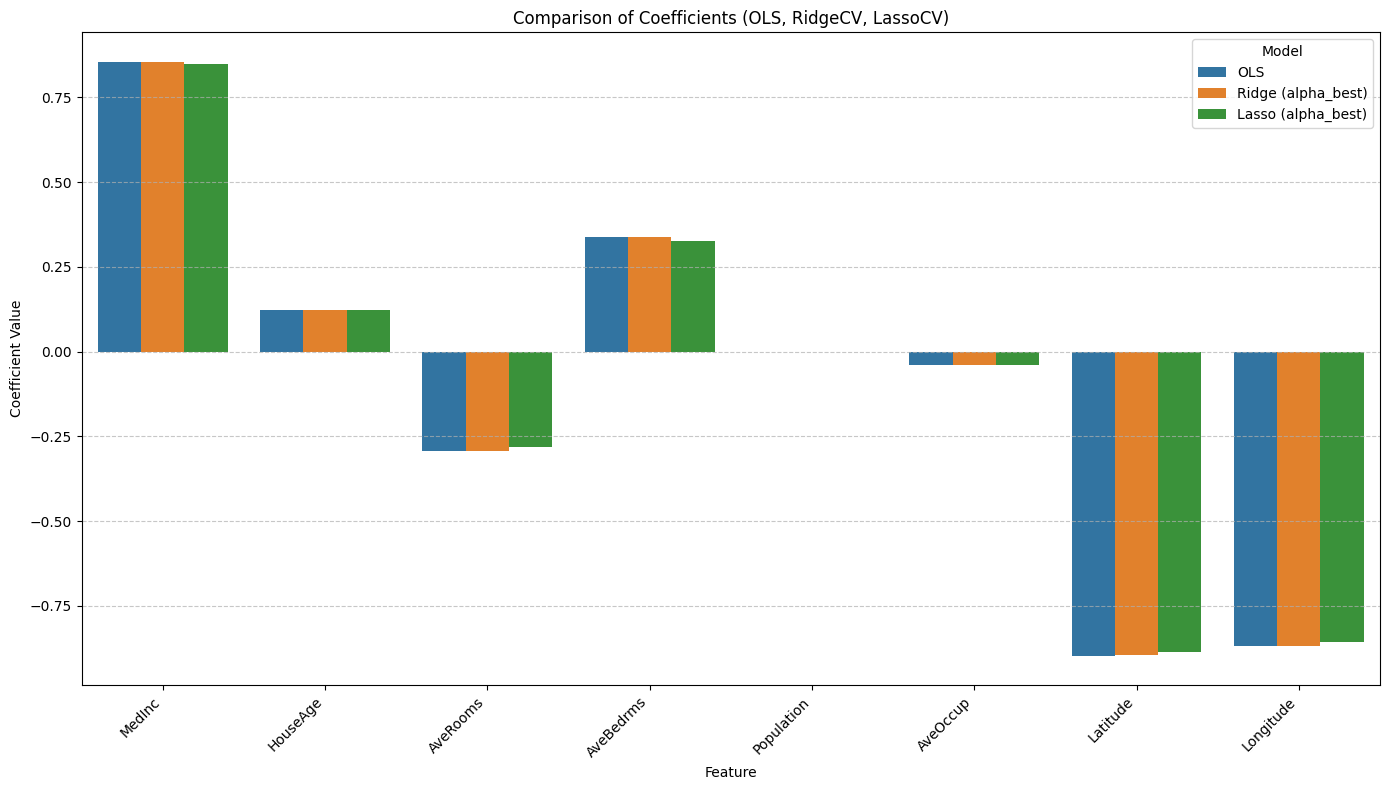

In [19]:
# Visualizing Coefficients (OLS, Ridge, Lasso)
plt.figure(figsize=(12, 7))
coef_comparison = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'OLS': ols_model.coef_,
    'Ridge (alpha_best)': ridge_cv_model.coef_,
    'Lasso (alpha_best)': lasso_cv_model.coef_
})
coef_comparison_melted = coef_comparison.melt(id_vars='Feature', var_name='Model', value_name='Coefficient Value')

# Using seaborn for potentially nicer bar plot
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.barplot(x='Feature', y='Coefficient Value', hue='Model', data=coef_comparison_melted)
plt.title('Comparison of Coefficients (OLS, RidgeCV, LassoCV)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observations from Lasso:**
* You should observe that with an appropriate `alpha`, some of the coefficients from the `LassoCV` model are exactly zero. This demonstrates Lasso's feature selection capability.
* The performance (MSE, R-squared) of Lasso might be better or worse than Ridge or OLS, depending on the dataset. If many features are truly irrelevant, Lasso can sometimes outperform Ridge by effectively removing that noise.
* The plot comparing coefficients will visually highlight how Lasso "zeros out" some features, while Ridge tends to shrink all coefficients more uniformly (but not to exact zero).

Lasso is a very valuable tool when you want a more parsimonious model (a model with fewer features) or when you are dealing with a large number of predictors and need to identify the most important ones.